# Imports

In [1]:
import os
os.chdir(r'C:\Projetos\case-ami-saude')

In [2]:
import pandas as pd
import numpy as np
import re
from src.utils import pipeline_universal_limpeza , cid_formato_valido , cid_compativel_especialidade
from src.utils import OutlierConfig, find_outliers, filter_outlier_rows, plot_outlier_boxplots, boxplot_iqr_todas_colunas

# Exploração univariada - Base 01

## Data Exploration

### Verificação dos cids:

* Verificar se os cids estão no formato esperado:
    * Todos os cids estão no formato esperado: Letra - 2 numeros
* Verificar se o CID existe:
    * Todos os cids pertencem a uma catégoria existente de CID.
* O cid está correto conforme especialidade médica?
    * Para autorias foi criado um mapa para verificar se o cid corresponde a especialidade médica correta:
        * Identificação de 16704 que precisam de atenção no cid principal,
        * Identificação de 7451 que precisam de atenção no cid secundário,
* Em uma internação hospitalar:
    * CID principal representa o motivo da internação
    * CID secundário representa comorbidades ou condições associadas
* Na prática, erros comuns acontecem:
    * CID genérico como principal (R/Z)
    * CID compatível com a especialidade ficando como secundário
    * CID obstétrico ou psiquiátrico fora do principal
    * Houve um achado de 3,13% dos cids secundários terem fores indícios de invesão com o principal.
    * Aproximadamente 48% dos cids precisam revisar.


In [18]:
df_cid = pd.read_csv(r'C:\Projetos\case-ami-saude\data\raw\CID-10-CATEGORIAS.CSV',sep=';', encoding='latin-1')
df_cid

,CAT,CLASSIF,DESCRICAO,DESCRABREV,REFER,EXCLUIDOS,Unnamed: 6
0,A00,NaN,Cólera,A00 Colera,NaN,NaN,NaN
1,A01,NaN,Febres tifóide e paratifóide,A01 Febres tifoide e paratifoide,NaN,NaN,NaN
2,A02,NaN,Outras infecções por Salmonella,A02 Outr infecc p/Salmonella,NaN,NaN,NaN
3,A03,NaN,Shiguelose,A03 Shiguelose,NaN,NaN,NaN
4,A04,NaN,Outras infecções intestinais bacterianas,A04 Outr infecc intestinais bacter,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2040,U80,NaN,Agente resistente à penicilina e antibióticos ...,U80 Agente resist penicilina e antibiót relac,NaN,NaN,NaN
2041,U81,NaN,Agente resistente à vancomicina e antibióticos...,U81 Agente resist vancomicina e antibiót relac,NaN,NaN,NaN
2042,U88,NaN,Agente resistente a múltiplos antibióticos,U88 Agente resistente a múltiplos antibióticos,NaN,NaN,NaN
2043,U89,NaN,Agente resistente a outros antibióticos e a an...,U89 Agente resist outr antibiót e antibiót NE,NaN,NaN,NaN


In [19]:
# Verificar formato dos CID-10
cid_pattern = re.compile(r"^[A-Z][0-9]{2}$")

df_base_01["cid_principal_formato_ok"] = df_base_01["cid_principal"].str.match(cid_pattern)
df_base_01["cid_secundario_formato_ok"] = df_base_01["cid_secundario"].str.match(cid_pattern)


In [20]:
# Os CID-10 devem seguir o formato letra maiúscula seguida de dois dígitos (ex: A00, B99)
filtro_cid = df_base_01[
    (df_base_01["cid_principal_formato_ok"] == False) |
    (df_base_01["cid_secundario_formato_ok"] == False)
]
filtro_cid[["cid_principal", "cid_secundario", "cid_principal_formato_ok", "cid_secundario_formato_ok"]]


,cid_principal,cid_secundario,cid_principal_formato_ok,cid_secundario_formato_ok


In [21]:
# Verificar se o CID está presente na tabela de categorias CID-10
cids_validos = set(df_cid['CAT'])

df_base_01["cid_principal_valido"] = df_base_01["cid_principal"].isin(cids_validos)
df_base_01["cid_secundario_valido"] = (df_base_01["cid_secundario"].isna() | df_base_01["cid_secundario"].isin(cids_validos))

In [22]:
filtro_cid_validos = df_base_01[
    (df_base_01["cid_principal_valido"] == False) |
    (df_base_01["cid_secundario_valido"] == False)
]
filtro_cid_validos[["cid_principal", "cid_secundario", "cid_principal_valido", "cid_secundario_valido"]]

,cid_principal,cid_secundario,cid_principal_valido,cid_secundario_valido


In [23]:
# Verificar se o CID pertence a especialidade médica

mapa_especialidade_cid = {
    "Clínica Médica": (
        "A","B","E","I","J","K","N","R"
    ),
    "Pediatria": (
        "A","B","E","J","P","Q","R","Z"
    ),
    "Oncologia": (
        "C","D"
    ),
    "Nefrologia": (
        "N"
    ),
    "Ginecologia/Obstetrícia": (
        "O","N"
    ),
    "Pneumologia": (
        "J"
    ),
    "Cardiologia": (
        "I"
    ),
    "Gastroenterologia": (
        "K"
    ),
    "Ortopedia": (
        "M","S","T"
    ),
    "Neurologia": (
        "G","I"
    ),
    "Infectologia": (
        "A","B"
    ),
}


df_base_01["cid_principal_compativel_especialidade"] = df_base_01.apply(
    lambda x: cid_compativel_especialidade(
        x["cid_principal"],
        x["especialidade_responsavel"],
        mapa_especialidade_cid
    ),
    axis=1
)

df_base_01["cid_secundario_compativel_especialidade"] = df_base_01.apply(
    lambda x: cid_compativel_especialidade(
        x["cid_secundario"],
        x["especialidade_responsavel"],
        mapa_especialidade_cid
    ),
    axis=1
)

In [24]:
df_base_01['cid_principal_compativel_especialidade'].value_counts()

cid_principal_compativel_especialidade
False    16704
True      3296
Name: count, dtype: int64

In [25]:
df_base_01['cid_secundario_compativel_especialidade'].value_counts()

cid_secundario_compativel_especialidade
True     12549
False     7451
Name: count, dtype: int64

In [26]:
# Cid secundário poderia ser o primario:
cidp = df_base_01["cid_principal"].astype("string").str.strip().str.upper()
cids = df_base_01["cid_secundario"].astype("string").str.strip().str.upper()

tipo = df_base_01["tipo_internacao"].astype("string").str.strip()
carater = df_base_01["carater_internacao"].astype("string").str.strip()
esp = df_base_01["especialidade_responsavel"].astype("string").str.strip()

In [27]:
# Camada 1- 
"""
Tipo de internação Obstétrica → CID principal deve ser capítulo O

Tipo de internação Psiquiátrica → CID principal deve ser capítulo F 
"""

df_base_01["alerta_swap_obstetrica"] = (
    (tipo == "Obstétrica")
    & ~cidp.str.startswith("O", na=False)
    & cids.str.startswith("O", na=False)
)
df_base_01["alerta_swap_psiquiatrica"] = (
    (tipo == "Psiquiátrica")
    & ~cidp.str.startswith("F", na=False)
    & cids.str.startswith("F", na=False)
)


In [28]:
# Camada 2 - CID secundário mais compatível com a especialidade do que o CID principal

df_base_01["cidp_comp_esp"] = df_base_01.apply(
    lambda x: cid_compativel_especialidade(x["cid_principal"], x["especialidade_responsavel"], mapa_especialidade_cid),
    axis=1
)

df_base_01["cids_comp_esp"] = df_base_01.apply(
    lambda x: cid_compativel_especialidade(x["cid_secundario"], x["especialidade_responsavel"], mapa_especialidade_cid),
    axis=1
)

df_base_01["alerta_swap_especialidade"] = (~df_base_01["cidp_comp_esp"]) & (df_base_01["cids_comp_esp"])


In [29]:
# Camada 3 - CIDs genéricos (capítulos R e Z) não deveriam ser principais se houver um CID específico presente
"""
CIDs dos capítulos R e Z são frequentemente usados como diagnóstico provisório.
Quando eles aparecem como principal e existe um CID secundário mais específico, isso é um padrão clássico de hierarquia invertida.
"""
df_base_01["alerta_swap_generico"] = (
    cidp.str.startswith(("R","Z"), na=False)
    & cids.notna()
    & ~cids.str.startswith(("R","Z"), na=False)
)


In [30]:
# Camada 4 - Para internações eletivas, se o CID principal for de Ortopedia (capítulos S ou T), mas houver um CID secundário compatível com a especialidade, pode ser um swap de CID
"""
Eu não usei caráter como regra dura, mas como priorização.
Por exemplo, trauma como CID principal em internação eletiva é raro. Quando isso acontecia e o secundário era compatível com a especialidade, eu marcava como suspeito.
"""

df_base_01["alerta_swap_carater"] = (
    (carater == "Eletiva")
    & cidp.str.startswith(("S","T"), na=False)
    & df_base_01["cids_comp_esp"]  # secundário faz mais sentido pro setor
)


In [31]:
swap_cols = [
    "alerta_swap_obstetrica",
    "alerta_swap_psiquiatrica",
    "alerta_swap_especialidade",
    "alerta_swap_generico",
    "alerta_swap_carater",
]

df_base_01["alerta_swap"] = df_base_01[swap_cols].any(axis=1)
df_base_01["score_swap"] = df_base_01[swap_cols].sum(axis=1)


In [32]:
# O score de swap é uma métrica que soma o número de alertas acionados para cada internação. Quanto maior o score, mais suspeita é a internação de ter um swap de CID.
""" 
SCORE 0 - Todas as camadas de alerta estão limpas, sem indícios de swap de CID
SCORE 1 - Apenas 1 camada de alerta acionada, suspeita leve de swap
SOCRE 2 - alta probabilidade de inversão
"""

df_base_01['score_swap'].value_counts(normalize=True) *100

score_swap
1    48.995
0     47.87
2     3.135
Name: proportion, dtype: Float64

## Detecção de outliers

In [33]:
df_base_01.columns

Index(['senha_internacao', 'beneficiario_id', 'numero_carteirinha',
       'nome_beneficiario', 'data_nascimento', 'idade', 'sexo', 'uf',
       'municipio', 'hospital_id', 'hospital_nome', 'perfil_hospital',
       'tipo_plano', 'segmentacao_plano', 'acomodacao',
       'data_solicitacao_autorizacao', 'data_autorizacao_senha',
       'data_admissao', 'data_alta', 'motivo_alta', 'carater_internacao',
       'tipo_internacao', 'especialidade_responsavel', 'cid_principal',
       'cid_secundario', 'complexidade', 'uti_flag',
       'suporte_ventilatorio_flag', 'hemodialise_flag',
       'tempo_autorizacao_horas', 'auditoria_responsavel', 'empresa_auditoria',
       'status_regulacao', 'glosa_flag', 'valor_total_conta', 'valor_pago',
       'tempo_autorizacao_horas_new', 'cid_principal_formato_ok',
       'cid_secundario_formato_ok', 'cid_principal_valido',
       'cid_secundario_valido', 'cid_principal_compativel_especialidade',
       'cid_secundario_compativel_especialidade', 'alerta_s

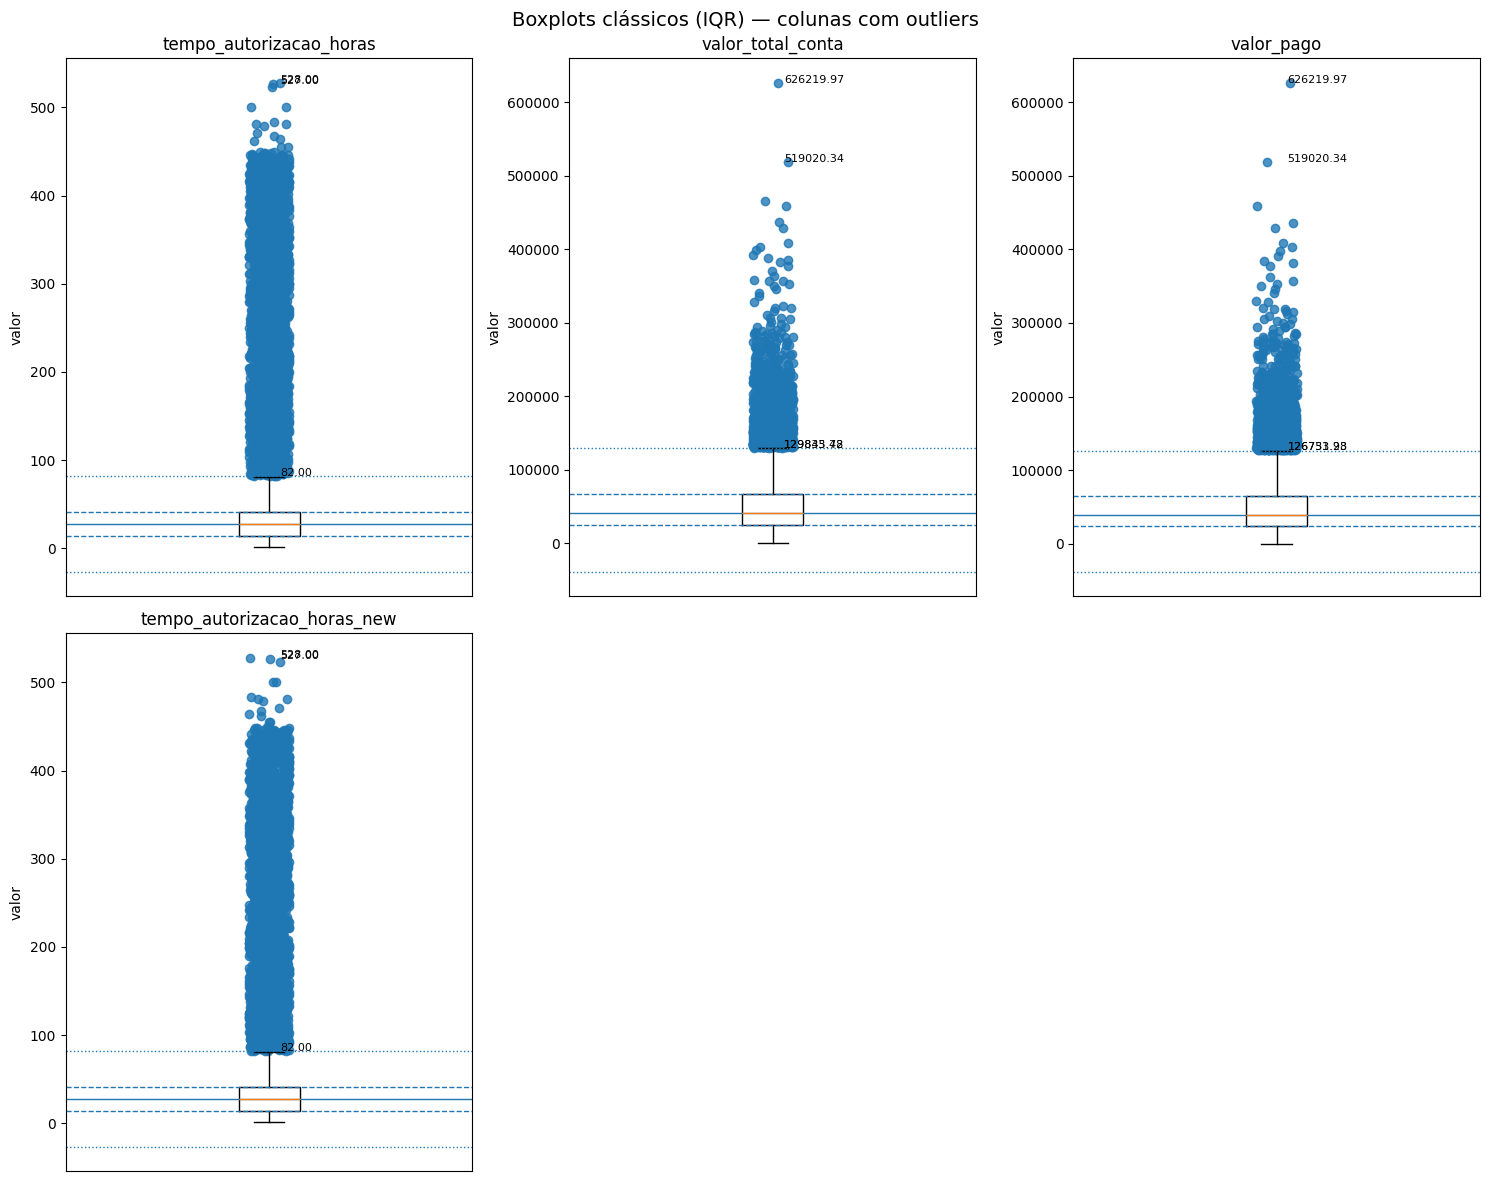

In [34]:
excluir_colunas  = [
    'senha_internacao',
    'beneficiario_id',
    'numero_carteirinha',
    'nome_beneficiario',
    'data_nascimento',
    'hospital_id', 
    'hospital_nome',
]


cfg = OutlierConfig(method="iqr", iqr_k=1.5, exclude_cols=[excluir_colunas])
report, mask = find_outliers(df_base_01, cfg)

boxplot_iqr_todas_colunas(
    df=df_base_01,
    mask=mask,
    ncols=3
)

# Exploração Univariada - Base 02

## Data Exploration

In [35]:
path_base_02 = r'C:\Projetos\case-ami-saude\data\raw\Base 2 – Itens da Internação.csv'
df_base_02 = pd.read_csv(path_base_02)
df_base_02


,item_id,senha_internacao,data_item,tipo_item,subtipo_item,codigo_item,descricao_item,quantidade_solicitada,quantidade_autorizada,unidade_medida,valor_unitario,valor_total_item,setor_execucao,flag_pacote,glosa_item_flag,motivo_glosa,valor_glosado
0,IT000047081,SI20250002374,2025-04-23 16:36:36,Exame,Exames de imagem (un),EX_IMG,Exames de imagem (un),2,2,un,1675.92,3351.84,SADT,Não,Sim,Administrativa - código incompatível,3351.84
1,IT000290746,SI20250014538,2024-08-17 05:07:19,Taxa,Honorários (un),TX_HON,Honorários (un),3,3,un,1158.60,3475.80,Administrativo,Não,Sim,Técnica - item não pertinente ao CID,3475.80
2,IT000341194,SI20250017099,2024-10-12 09:09:58,Procedimento,Procedimento Cirúrgico,PR_CIR,Procedimento Cirúrgico,1,1,un,4314.57,4314.57,Centro Cirúrgico,Não,Não,NaN,0.00
3,IT000179585,SI20250008978,2025-10-23 17:20:13,Diária,Diária Enfermaria,DI_ENF,Diária Enfermaria,8,8,diária,559.87,4478.96,Enfermaria,Não,Não,NaN,0.00
4,IT000367705,SI20250018405,2024-07-31 13:28:24,Medicamento,Medicamentos (dose),MD_GER,Medicamentos (dose),4,4,dose,89.72,358.88,Farmácia,Não,Não,NaN,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,IT000401849,SI20250011218,2025-06-23 13:45:13,Diária,Diária Enfermaria,DI_ENF,Diária Enfermaria,17,17,diária,1369.52,23281.77,Enfermaria,Não,Não,NaN,0.00
399996,IT000401850,SI20250004187,2025-10-11 17:31:34,Medicamento,Antibiótico (dose),MD_ATB,Antibiótico (dose),2,2,dose,62.85,125.70,Farmácia,Não,Não,NaN,0.00
399997,IT000401851,SI20250011297,2025-06-20 20:24:33,Taxa,Taxas e materiais (un),TX_MAT,Taxas e materiais (un),1,0,un,210.93,0.00,Enfermaria,Não,Não,NaN,0.00
399998,IT000401852,SI20250009120,2025-11-21 00:11:00,Terapia seriada,Fonoaudiologia (sessão),TS_FON,Fonoaudiologia (sessão),4,4,sessão,84.44,337.76,Enfermaria,Não,Não,NaN,0.00


### Tipagem dos dados:

In [36]:
df_base_02 = pipeline_universal_limpeza(df_base_02)

### Análise de dados:

* Valores nulos
* Valores Faltantes
* Análises estatísticas

In [37]:
df_base_02.duplicated().sum()

np.int64(0)

In [38]:
df_base_02.isna().sum()

item_id                       0
senha_internacao              0
data_item                     0
tipo_item                     0
subtipo_item                  0
codigo_item                   0
descricao_item                0
quantidade_solicitada         0
quantidade_autorizada         0
unidade_medida                0
valor_unitario                0
valor_total_item              0
setor_execucao                0
flag_pacote                   0
glosa_item_flag               0
motivo_glosa             385739
valor_glosado                 0
dtype: int64

In [39]:
df_base_02.describe()

,data_item,quantidade_solicitada,quantidade_autorizada,valor_unitario,valor_total_item,valor_glosado
count,400000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000
mean,2025-04-08 06:12:33.454392320,10.117392,9.728160,1105.629264,2596.045271,70.249906
min,2024-07-01 08:53:00,1.000000,0.000000,9.830000,0.000000,0.000000
25%,2024-11-21 04:30:44.500000,1.000000,1.000000,96.540000,523.757500,0.000000
50%,2025-04-08 01:55:34,4.000000,3.000000,207.210000,1270.120000,0.000000
75%,2025-08-23 13:35:36.750000128,11.000000,10.000000,907.950000,2896.830000,0.000000
max,2026-01-30 13:53:14,109.000000,109.000000,104936.330000,138741.210000,63577.800000
std,NaN,14.222409,13.956731,2958.618241,4161.837195,667.575420


# Exploração Multivariada

## Intercessão de colunas

In [40]:
colunas_iguais = set(df_base_01.columns).intersection(set(df_base_02.columns))
colunas_iguais

{'senha_internacao'}

### Qualidade da senha de internação:

* A quantidade de senhas de internação é a mesma nas duas bases?
* A senha de internação não encontrada está com os mesmos padrões das demais?
     * Tem como resolver?


In [41]:
df_base_01['senha_internacao'].nunique()

20000

In [42]:
df_base_02['senha_internacao'].nunique()

20005

In [43]:
internacao_nao_encontradas = df_base_02[~df_base_02['senha_internacao'].isin(df_base_01['senha_internacao'])]
internacao_nao_encontradas

,item_id,senha_internacao,data_item,tipo_item,subtipo_item,codigo_item,descricao_item,quantidade_solicitada,quantidade_autorizada,unidade_medida,valor_unitario,valor_total_item,setor_execucao,flag_pacote,glosa_item_flag,motivo_glosa,valor_glosado
398390,IT000400244,SX67887514,2025-06-21 16:00:00,Exame,Imagem,EX_ORF,Exame não vinculado (anomalia),1,1,exame,450.0,450.0,Diagnóstico,Não,Não,NaN,0.0
398391,IT000400245,SX45920556,2025-06-17 20:00:00,Exame,Imagem,EX_ORF,Exame não vinculado (anomalia),1,1,exame,450.0,450.0,Diagnóstico,Não,Não,NaN,0.0
398392,IT000400246,SX54154075,2025-06-17 11:00:00,Exame,Imagem,EX_ORF,Exame não vinculado (anomalia),1,1,exame,450.0,450.0,Diagnóstico,Não,Não,NaN,0.0
398393,IT000400247,SX25817033,2025-06-18 12:00:00,Exame,Imagem,EX_ORF,Exame não vinculado (anomalia),1,1,exame,450.0,450.0,Diagnóstico,Não,Não,NaN,0.0
398394,IT000400248,SX52954311,2025-06-16 12:00:00,Exame,Imagem,EX_ORF,Exame não vinculado (anomalia),1,1,exame,450.0,450.0,Diagnóstico,Não,Não,NaN,0.0
398395,IT000400249,SX45763098,2025-06-20 23:00:00,Exame,Imagem,EX_ORF,Exame não vinculado (anomalia),1,1,exame,450.0,450.0,Diagnóstico,Não,Não,NaN,0.0
398396,IT000400250,SX69652955,2025-06-23 05:00:00,Exame,Imagem,EX_ORF,Exame não vinculado (anomalia),1,1,exame,450.0,450.0,Diagnóstico,Não,Não,NaN,0.0
398397,IT000400251,SX45382871,2025-06-16 07:00:00,Exame,Imagem,EX_ORF,Exame não vinculado (anomalia),1,1,exame,450.0,450.0,Diagnóstico,Não,Não,NaN,0.0
398398,IT000400252,SX29510197,2025-06-17 20:00:00,Exame,Imagem,EX_ORF,Exame não vinculado (anomalia),1,1,exame,450.0,450.0,Diagnóstico,Não,Não,NaN,0.0
398399,IT000400253,SX83164356,2025-06-18 03:00:00,Exame,Imagem,EX_ORF,Exame não vinculado (anomalia),1,1,exame,450.0,450.0,Diagnóstico,Não,Não,NaN,0.0
